In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
from sklearn.utils import shuffle
import nltk
nltk.download('punkt')

import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, Bidirectional, Dropout
import tensorflow.keras.layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Read in the data
from google.colab import files
uploaded = files.upload()

Saving Fake.csv to Fake.csv
Saving Real.csv to Real.csv


In [309]:
import io
fake = pd.read_csv(io.BytesIO(uploaded['Fake.csv']))
real = pd.read_csv(io.BytesIO(uploaded['Real.csv']))

print(fake.shape)
print(real.shape)

(23481, 4)
(21417, 4)


# Feature Engineering and Preprocess

In [310]:
fake['isfake'] = 1
real['isfake'] = 0

df = pd.concat([fake, real]).reset_index(drop=True)

#shuffle data
df = shuffle(df)
df = df.reset_index(drop=True)

df.drop(columns = ['date'], inplace=True)

#Combine title and text together
df['all_text'] = df['title'] + ' ' + df['text']

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(text):
    '''
    -Remove all stopwords and words with two or less characters
    '''
    res = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            res.append(token)
            
    return res

df['clean'] = df['all_text'].apply(remove_stopwords)

df['clean_joined'] = df['clean'].apply(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [311]:
X = df.clean_joined
y = df.isfake

print(X.shape)
print(y.shape)

(44898,)
(44898,)


In [312]:
#Use keras tokenizer to vectorize text

tokenizer = Tokenizer(num_words = 10_000)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=700)

y = pd.get_dummies(df.isfake,columns=df.isfake).values #Logit and labels must have the same shape

In [313]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [314]:
# google = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [315]:
# download google word2vec pretrained embedding 

!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-05-19 10:50:36--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.0.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.0.150|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [316]:
import os
os.chdir("/root/input")
!ls -al

total 1772264
drwxr-xr-x 2 root root       4096 May 19 07:20 .
drwx------ 1 root root       4096 May 19 06:17 ..
-rw-r--r-- 1 root root  133453320 May 19 06:49 fake-news-model.h5
-rw-r--r-- 1 root root 1647046227 Mar  5  2015 GoogleNews-vectors-negative300.bin.gz
-rw-r--r-- 1 root root   28822234 May 19 06:33 model.zip
-rw-r--r-- 1 root root    5455529 May 19 09:08 tokenizer.tk


In [317]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'

google = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True, limit=500000)

In [318]:
#extracting word vectors from google news vector
embeddings_index = {}
for word, vector in zip(google.vocab, google.vectors):
    coefs = np.asarray(vector, dtype='float32')
    embeddings_index[word] = coefs

In [319]:
print('Found %s word vectors.' % len(embeddings_index))

Found 500000 word vectors.


In [320]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

vocab_size = len(tokenizer.word_index) + 1 
print(vocab_size)

Found 108456 unique tokens.
108457


In [321]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Model Training and Evaluation

In [322]:
model = Sequential()

#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=300, weights=[embedding_matrix], input_length=700, trainable=False))
    
model.add(LSTM(units=128 , return_sequences = True))
# model.add(Dropout(0.2))
model.add(LSTM(units=64))
# model.add(Dropout(0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 700, 300)          32537100  
_________________________________________________________________
lstm_28 (LSTM)               (None, 700, 128)          219648    
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 66        
Total params: 32,808,302
Trainable params: 271,202
Non-trainable params: 32,537,100
_________________________________________________________________


In [323]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)

#Early stopping to find optimal number of epochs to prevent overfitting/underfitting

In [324]:
history = model.fit(x_train,y_train,batch_size = 64 , validation_data = (x_test,y_test) , epochs = 50, callbacks =[earlystopping])

Epoch 1/50
492/492 [==============================] - 49s 95ms/step - loss: 0.3243 - accuracy: 0.8660 - val_loss: 0.1950 - val_accuracy: 0.9267
Epoch 2/50
492/492 [==============================] - 45s 92ms/step - loss: 0.1500 - accuracy: 0.9465 - val_loss: 0.0538 - val_accuracy: 0.9860
Epoch 3/50
492/492 [==============================] - 46s 93ms/step - loss: 0.0745 - accuracy: 0.9770 - val_loss: 0.0339 - val_accuracy: 0.9932
Epoch 4/50
492/492 [==============================] - 45s 92ms/step - loss: 0.0276 - accuracy: 0.9939 - val_loss: 0.0228 - val_accuracy: 0.9957
Epoch 5/50
492/492 [==============================] - 45s 92ms/step - loss: 0.0296 - accuracy: 0.9923 - val_loss: 0.0460 - val_accuracy: 0.9879
Epoch 6/50
492/492 [==============================] - 45s 92ms/step - loss: 0.0501 - accuracy: 0.9835 - val_loss: 0.0133 - val_accuracy: 0.9973
Epoch 7/50
492/492 [==============================] - 45s 92ms/step - loss: 0.0379 - accuracy: 0.9904 - val_loss: 0.0147 - val_accuracy:

In [325]:
#Return indicies of max values

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [326]:
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy : ", accuracy)
print(classification_report(y_test, y_pred))

Model Accuracy :  0.9992576095025983
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6373
           1       1.00      1.00      1.00      7097

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



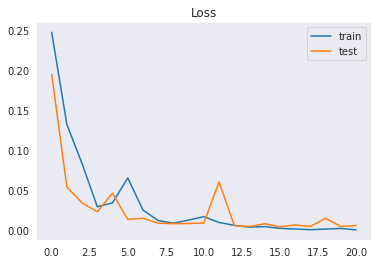

In [327]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

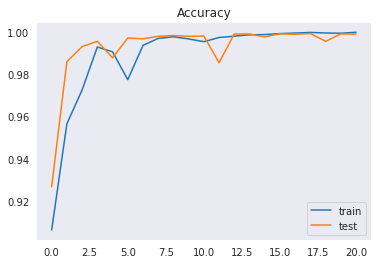

In [328]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [330]:
from google.colab import files
import pickle 
with open('tokenizer.tk', 'wb') as tokenizer_file:
 
  # Step 3
  pickle.dump(tokenizer, tokenizer_file)

In [331]:
files.download('tokenizer.h5')
files.download('model_v1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>